# Libraries & Settings

In [3]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import qgrid
from datetime import datetime as dtt

from pa_lib.file import data_files, load_bin, store_bin, load_csv, write_xlsx, load_xlsx
from pa_lib.data import (calc_col_partitioned, clean_up_categoricals, flatten, 
                         replace_col, cond_col, desc_col, unfactorize, as_dtype, flatten_multi_index_cols)
from pa_lib.util import obj_size, cap_words
from pa_lib.log  import time_log, info
from pa_lib.vis import dive

# display long columns completely, show more rows
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 200)

def qshow(df, fit_width=False):
    return qgrid.show_grid(df, grid_options={'forceFitColumns': fit_width, 'fullWidthRows': False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data file

In [6]:
data_files('PP*')

,size,mtime
name,,
PPI_Pivot_2019_AGH.csv,160.4 MB,16.07.19 11:34:00


In [7]:
ppi_data = (load_csv('PPI_Pivot_2019_AGH.csv', sep=';', encoding='cp1252')
            .rename(mapper=lambda name: cap_words(name, sep='_'), axis='columns'))

2019-07-29 14:28:42 [INFO] Reading from file /home/pa/data/PPI_Pivot_2019_AGH.csv
2019-07-29 14:28:47 [INFO] Finished loading CSV in 5.17s (6.16s CPU)


In [8]:
desc_col(ppi_data)

,DTYPE,NULLS,UNIQUE
Ppi_NR,int64,0/515036,1217
Kpg_Name,object,0/515036,1089
Jahr,int64,0/515036,17
Kunde,object,0/515036,267
Branche,object,0/515036,124
Gruppe,object,0/515036,58
Kategorie,object,0/515036,22
Std_Publ,object,0/515036,32
Alter_Jahre,int64,0/515036,62
Alter_15_25_35_49,object,0/515036,4


# Add columns
* Sum of answer weights per campaign
* Scaled answers (divided by sum of answer weights)
* Raw (uncorrected) answer values, will be 0 or 1
* Remap "Marke_Bekanntheit" [1..5] to "Marke_Bekannt": 'unknown' (NA), 'not' (1), 'low' (2, 3), 'high' (4, 5)

In [9]:
ppi_data.loc[:,'Kamp_Gew_Sum'] = ppi_data.groupby('Ppi_NR')['Gewichtung'].transform(sum)
ppi_data.loc[:,'Befr_Erinn_Prz'] = ppi_data.Befr_Erinnerung / ppi_data.Kamp_Gew_Sum
ppi_data.loc[:,'Befr_Zuord_Prz'] = ppi_data.Befr_Zuordnung / ppi_data.Kamp_Gew_Sum
ppi_data.loc[:,'Befr_Erinn_Raw'] = (ppi_data.Befr_Erinnerung / ppi_data.Gewichtung).astype('int')
ppi_data.loc[:,'Befr_Zuord_Raw'] = (ppi_data.Befr_Zuordnung / ppi_data.Gewichtung).astype('int')

ppi_data.loc[:,'Marke_Bekannt'] = ppi_data.Marke_Bekanntheit.map({1: 'not', 2: 'low', 3: 'low', 4: 'high', 5: 'high'}).fillna('unknown')

ppi_data.head(10)

,Ppi_NR,Kpg_Name,Jahr,Kunde,Branche,Gruppe,Kategorie,Std_Publ,Alter_Jahre,Alter_15_25_35_49,...,Marke,Marke_Bekanntheit,Marke_Sympathie,Marke_Nutzung,Kamp_Gew_Sum,Befr_Erinn_Prz,Befr_Zuord_Prz,Befr_Erinn_Raw,Befr_Zuord_Raw,Marke_Bekannt
0,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,21,15-24,...,NaN,NaN,NaN,NaN,310.99929,0.002599,0.0,1,0,unknown
1,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,20,15-24,...,NaN,NaN,NaN,NaN,310.99929,0.000000,0.0,0,0,unknown
2,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,16,15-24,...,NaN,NaN,NaN,NaN,310.99929,0.002599,0.0,1,0,unknown
3,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,22,15-24,...,NaN,NaN,NaN,NaN,310.99929,0.002599,0.0,1,0,unknown
4,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,42,35-49,...,NaN,NaN,NaN,NaN,310.99929,0.000000,0.0,0,0,unknown
5,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,27,25-34,...,NaN,NaN,NaN,NaN,310.99929,0.000000,0.0,0,0,unknown
6,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,21,15-24,...,NaN,NaN,NaN,NaN,310.99929,0.000000,0.0,0,0,unknown
7,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,25,25-34,...,NaN,NaN,NaN,NaN,310.99929,0.003132,0.0,1,0,unknown
8,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,42,35-49,...,NaN,NaN,NaN,NaN,310.99929,0.003909,0.0,1,0,unknown
9,277,Helvetia Patria,2003,Helvetia Patria Versicherungen,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,42,35-49,...,NaN,NaN,NaN,NaN,310.99929,0.000000,0.0,0,0,unknown


In [10]:
write_xlsx(ppi_data, 'ppi_data.xlsx', 'data')

2019-07-29 14:30:06 [INFO] Writing to file /home/pa/data/ppi_data.xlsx
2019-07-29 14:35:56 [INFO] Written 74.5 MB
2019-07-29 14:36:00 [INFO] Finished writing xlsx file in 373.11s (374.42s CPU)


# Check distribution of answers

In [11]:
ppi_data = load_xlsx('ppi_data.xlsx')

2019-07-29 14:39:13 [INFO] Reading from file /home/pa/data/ppi_data.xlsx
2019-07-29 14:43:24 [INFO] Finished loading xlsx file in 250.83s (252.22s CPU)


### Crosstable (0 = No, 1 = Yes)

In [12]:
pd.crosstab(index=ppi_data.Befr_Erinn_Raw, columns=ppi_data.Befr_Zuord_Raw, margins=True)

Befr_Zuord_Raw,0,1,All
Befr_Erinn_Raw,,,
0,282787,2,282789
1,77669,154578,232247
All,360456,154580,515036


### What is it with those two cases?

In [13]:
ppi_data.query('Befr_Erinn_Raw == 0 and Befr_Zuord_Raw == 1').T

,133601,133884
Ppi_NR,719,719
Kpg_Name,PKZ/FP: My Number One,PKZ/FP: My Number One
Jahr,2010,2010
Kunde,PKZ Burger-Kehl + Co. AG,PKZ Burger-Kehl + Co. AG
Branche,Kleidung (sonstige),Kleidung (sonstige)
Gruppe,Bekleidung / Wäsche,Bekleidung / Wäsche
Kategorie,Bekleidung / persönlicher Bedarf,Bekleidung / persönlicher Bedarf
Std_Publ,vêtements - mode,vêtements - mode
Alter_Jahre,53,36
Alter_15_25_35_49,autre,35-49


# Aggregation

#### Define aggregation funtion, incl. confidence intervals

In [14]:
import statsmodels.stats.api as sms
import statsmodels.emplike.descriptive as sed

def conf_int(s, alpha=0.05, low_limit=-1e10, high_limit=1e10, method='emplike'):
    if method=='t':
      ci = (sms.DescrStatsW(s).tconfint_mean(alpha=alpha) 
            if len(s) > 1 else (np.NaN, np.NaN))           # assumes t-Distribution
    elif method == 'emplike':
      ci = (sed.DescStatUV(s).ci_mean(sig=alpha) 
            if len(s) > 1 else (np.NaN, np.NaN))           # non-parametric, slower
    else:
      raise ValueError('method parameter must be one of ("t", "emplike")')
    return (max(ci[0], low_limit), min(ci[1], high_limit))

def aggregate_ppi(df, by_col, ci_method='emplike'):
    def first(seq):
        return seq[0]

    def second(seq):
        return seq[1]

    def ci(seq):
        return conf_int(seq, alpha=0.05, method=ci_method, low_limit=0, high_limit=1)

    summary = (df.groupby(by_col, observed=True)
               .agg({'Ppi_NR': 'nunique',
                     'Befr_Erinn_Prz': ['mean', ci], 
                     'Befr_Zuord_Prz': ['mean', ci], 
                     'Nettowirk_Prz': ['mean', ci]})
               .set_axis('Umfragen Erinn_mean Erinn_ci Zuord_mean Zuord_ci Nettowirk_mean Nettowirk_ci'.split(), 
                         axis='columns', inplace=False))
    result = summary.loc[:,['Umfragen']]
    for col in 'Erinn Zuord Nettowirk'.split():
        result[f'{col}_mean'] = summary[f'{col}_mean']
        ci_col = f'{col}_ci'
        result = result.assign(**{f'{col}_low': summary[ci_col].transform(first),
                                  f'{col}_high': summary[ci_col].transform(second)})
    return result

## Aggregate on campaign

In [16]:
ppi_kamp_data = (ppi_data.groupby('Ppi_NR')
                 .agg({'Kunde': 'last', 'Kpg_Name': 'last', 'Branche': 'last', 'Gruppe': 'last', 'Kategorie': 'last', 'Std_Publ': 'last', 
                       'Befr_Erinn_Prz': 'sum', 'Befr_Zuord_Prz': 'sum'})
                 .eval('Nettowirk_Prz = Befr_Zuord_Prz / Befr_Erinn_Prz')
                 .join(ppi_data.groupby('Ppi_NR').size().rename('Befr_N')))

write_xlsx(ppi_kamp_data, 'ppi_kamp.xlsx', 'data')
ppi_kamp_data.head(10)

2019-07-29 14:45:56 [INFO] Writing to file /home/pa/data/ppi_kamp.xlsx
2019-07-29 14:45:57 [INFO] Written 115.7 KB
2019-07-29 14:45:57 [INFO] Finished writing xlsx file in 0.26s (1.57s CPU)


,Kunde,Kpg_Name,Branche,Gruppe,Kategorie,Std_Publ,Befr_Erinn_Prz,Befr_Zuord_Prz,Nettowirk_Prz,Befr_N
Ppi_NR,,,,,,,,,,
277,Helvetia Patria Versicherungen,Helvetia Patria,Versicherungen (Image),Versicherungen,Finanzwirtschaft / Versicherung,Versicherungen,0.393419,0.033876,0.086108,311
278,JT International AG,Winston,Zigaretten,Tabakwaren,Tabakwaren,Non-food (übrige),0.392000,0.193441,0.493471,311
279,Migros GB - Produkt,Aperitif,Nährmittel,Nährmittel / Fertigspeisen,Nahrungsmittel,Food,0.517461,0.393669,0.760769,311
280,Froneri Switzerland S.A.,Frisco Extreme,Tiefkühlprodukte,Tiefkühlprodukte,Nahrungsmittel,Glacé / Eiskrem,0.882236,0.628994,0.712954,311
281,Schweizer Milchproduzenten SMP Genossenschaft,Glocke,Milch,Milchprodukte,Nahrungsmittel,Milchprodukte / Käse,0.686296,0.615168,0.896359,311
282,Unilever (Schweiz),Lipton Ice Tea,Süssgetränke,Alkoholfreie Getränke,Getränke,Alkoholfreie Getränke,0.511067,0.369101,0.722217,311
283,Nestlé Suisse S.A.,Thomy Senf,Suppen / Würzen / Saucen,Suppen / Würzen / Saucen,Nahrungsmittel,Food,0.576809,0.473141,0.820274,311
284,Sunrise Communications AG,Einfach wechseln,Telekommunikation Image,Telekommunikation,EDV / Büro,Telekommunikation,0.677061,0.559671,0.826617,308
285,Nestlé Suisse S.A.,Nestlé Bowl,Tiefkühlprodukte,Tiefkühlprodukte,Nahrungsmittel,Food - Neueinführungen,0.658480,0.212462,0.322655,308


In [17]:
_ = aggregate_ppi(ppi_kamp_data.reset_index(), by_col='Std_Publ', ci_method='emplike')
write_xlsx(_, 'ppi_kamp_by_std_publ.xlsx', 'data')
_

2019-07-29 14:46:11 [INFO] Writing to file /home/pa/data/ppi_kamp_by_std_publ.xlsx
2019-07-29 14:46:11 [INFO] Written 10.1 KB
2019-07-29 14:46:11 [INFO] Finished writing xlsx file in 0.02s (0.02s CPU)


,Umfragen,Erinn_mean,Erinn_low,Erinn_high,Zuord_mean,Zuord_low,Zuord_high,Nettowirk_mean,Nettowirk_low,Nettowirk_high
Std_Publ,,,,,,,,,,
Alkoholfreie Getränke,37,0.486174,0.442393,0.534637,0.387042,0.326825,0.448349,0.756816,0.666894,0.826382
Alkoholische Getränke,7,0.328154,0.268323,0.418906,0.182532,0.106935,0.251219,0.535977,0.337071,0.738078
Bank- / Finanz-DL,37,0.432934,0.383373,0.482094,0.221857,0.178008,0.277345,0.514737,0.430551,0.599031
"Bauen, Industrie, Einrichtung",37,0.422887,0.381346,0.465574,0.320507,0.269939,0.368588,0.721937,0.633701,0.790756
Dienstleistungen,54,0.371570,0.329351,0.419484,0.199929,0.156376,0.253536,0.480790,0.404967,0.559296
Energie - Gas,9,0.326289,0.227723,0.439216,0.162303,0.102198,0.236906,0.466098,0.393008,0.544103
Fahrzeuge,74,0.312020,0.292806,0.333633,0.179692,0.159517,0.202299,0.561877,0.515531,0.607245
Ferien,43,0.390661,0.345274,0.441408,0.222732,0.179064,0.276740,0.538923,0.465521,0.615166
Food,55,0.431491,0.386029,0.479205,0.318058,0.268420,0.373259,0.681993,0.618661,0.737102


#### Plot answer distributions

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

##### Global distributions

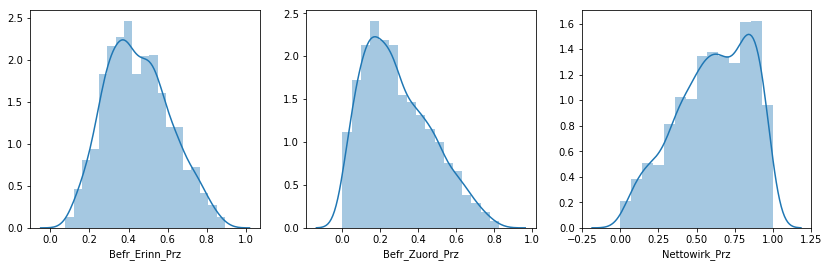

In [20]:
fig = plt.figure(1, figsize=(14,4), tight_layout=False)
plt.subplot(1,3,1)
sns.distplot(ppi_kamp_data.Befr_Erinn_Prz)
plt.subplot(1,3,2)
sns.distplot(ppi_kamp_data.Befr_Zuord_Prz)
plt.subplot(1,3,3)
sns.distplot(ppi_kamp_data.Nettowirk_Prz);

##### Distribution per Std_Publ

/home/pa/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pa/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


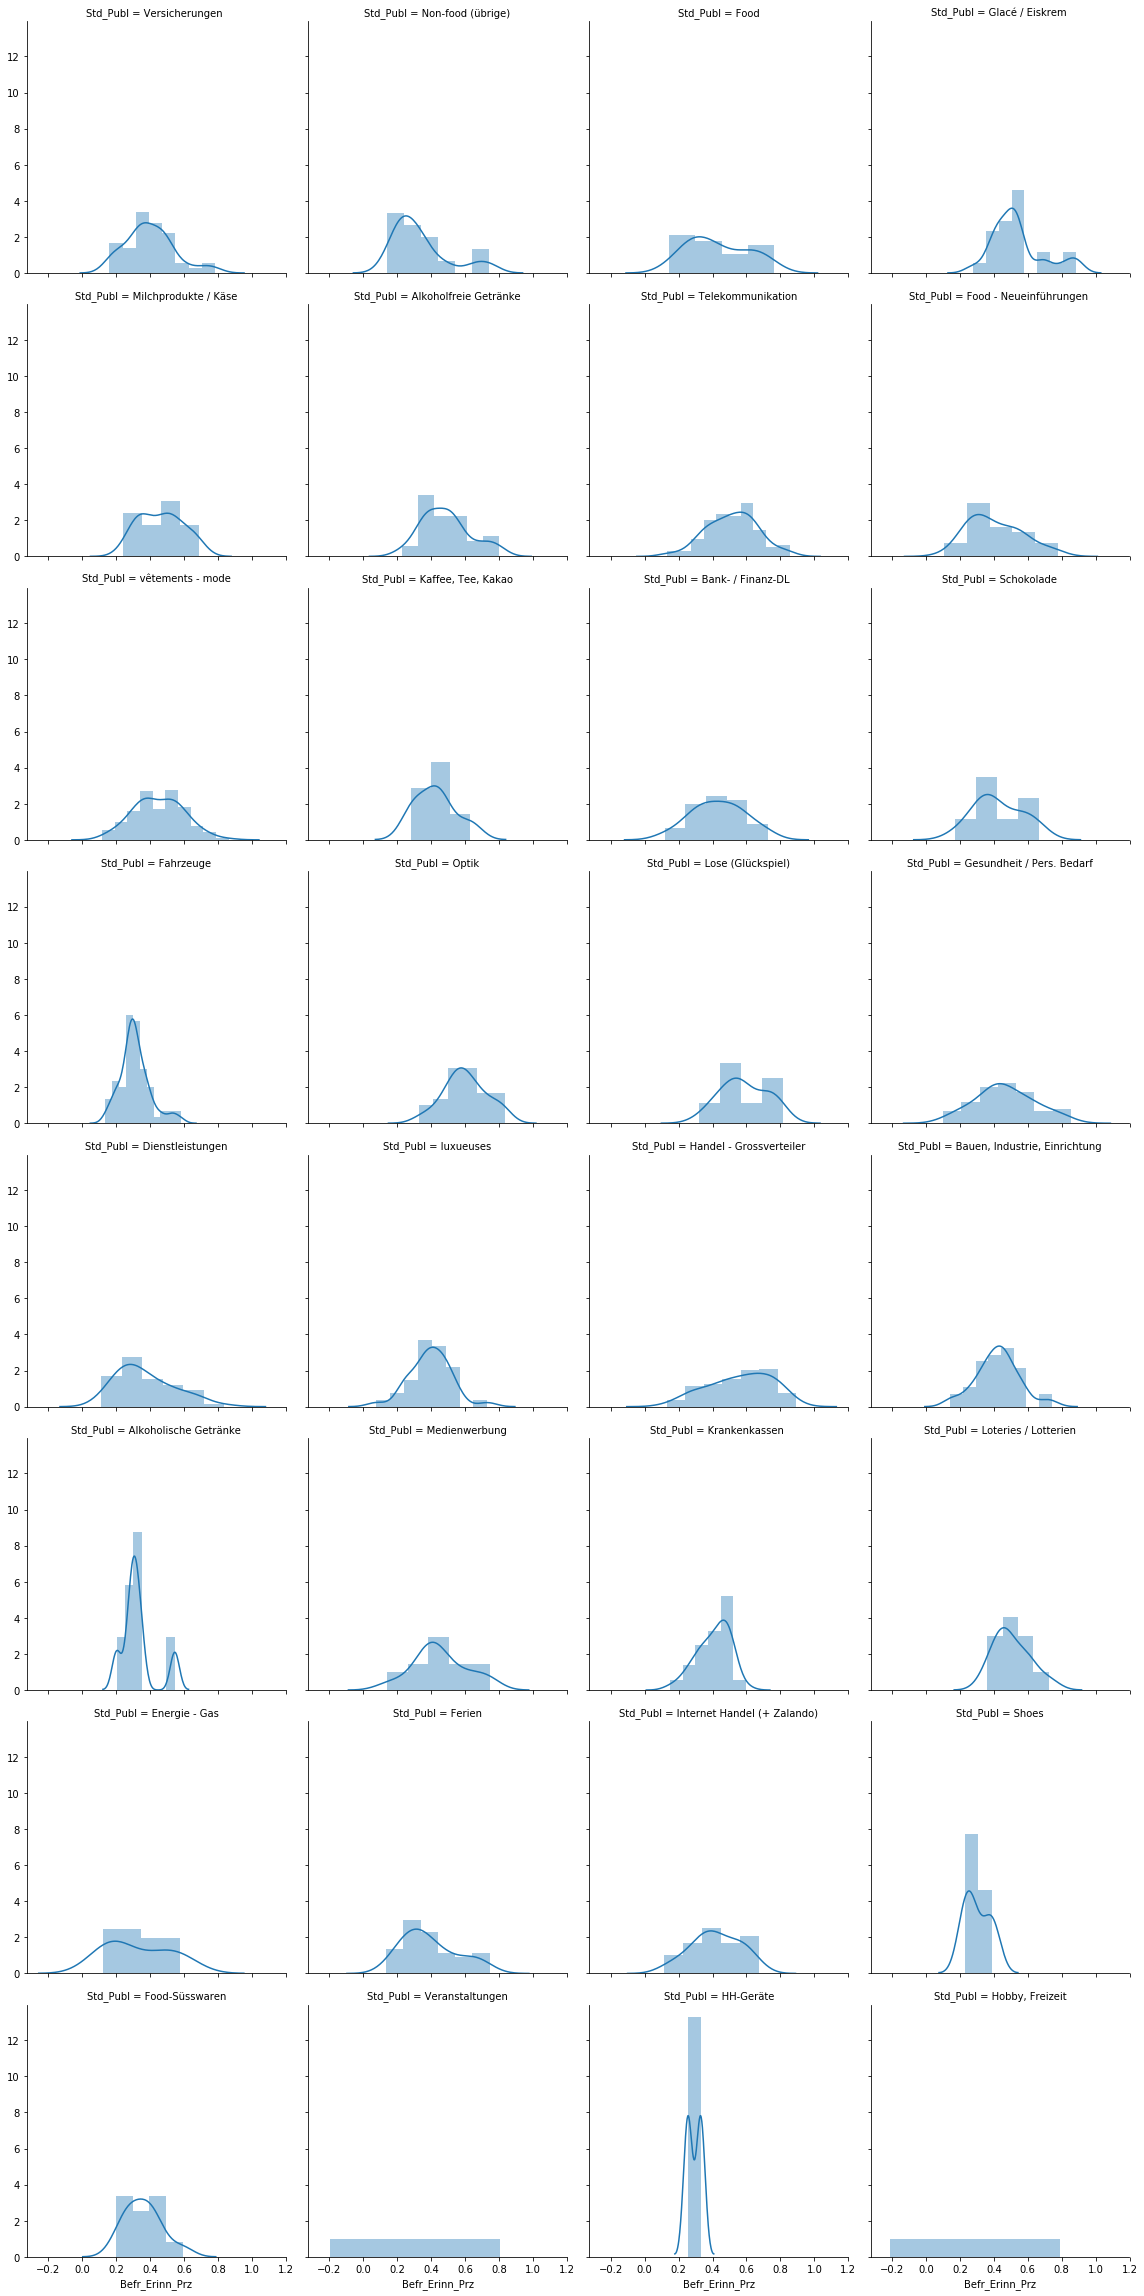

In [21]:
g = sns.FacetGrid(data=ppi_kamp_data, col="Std_Publ", col_wrap=4, height=4)
g.map(sns.distplot, 'Befr_Erinn_Prz');

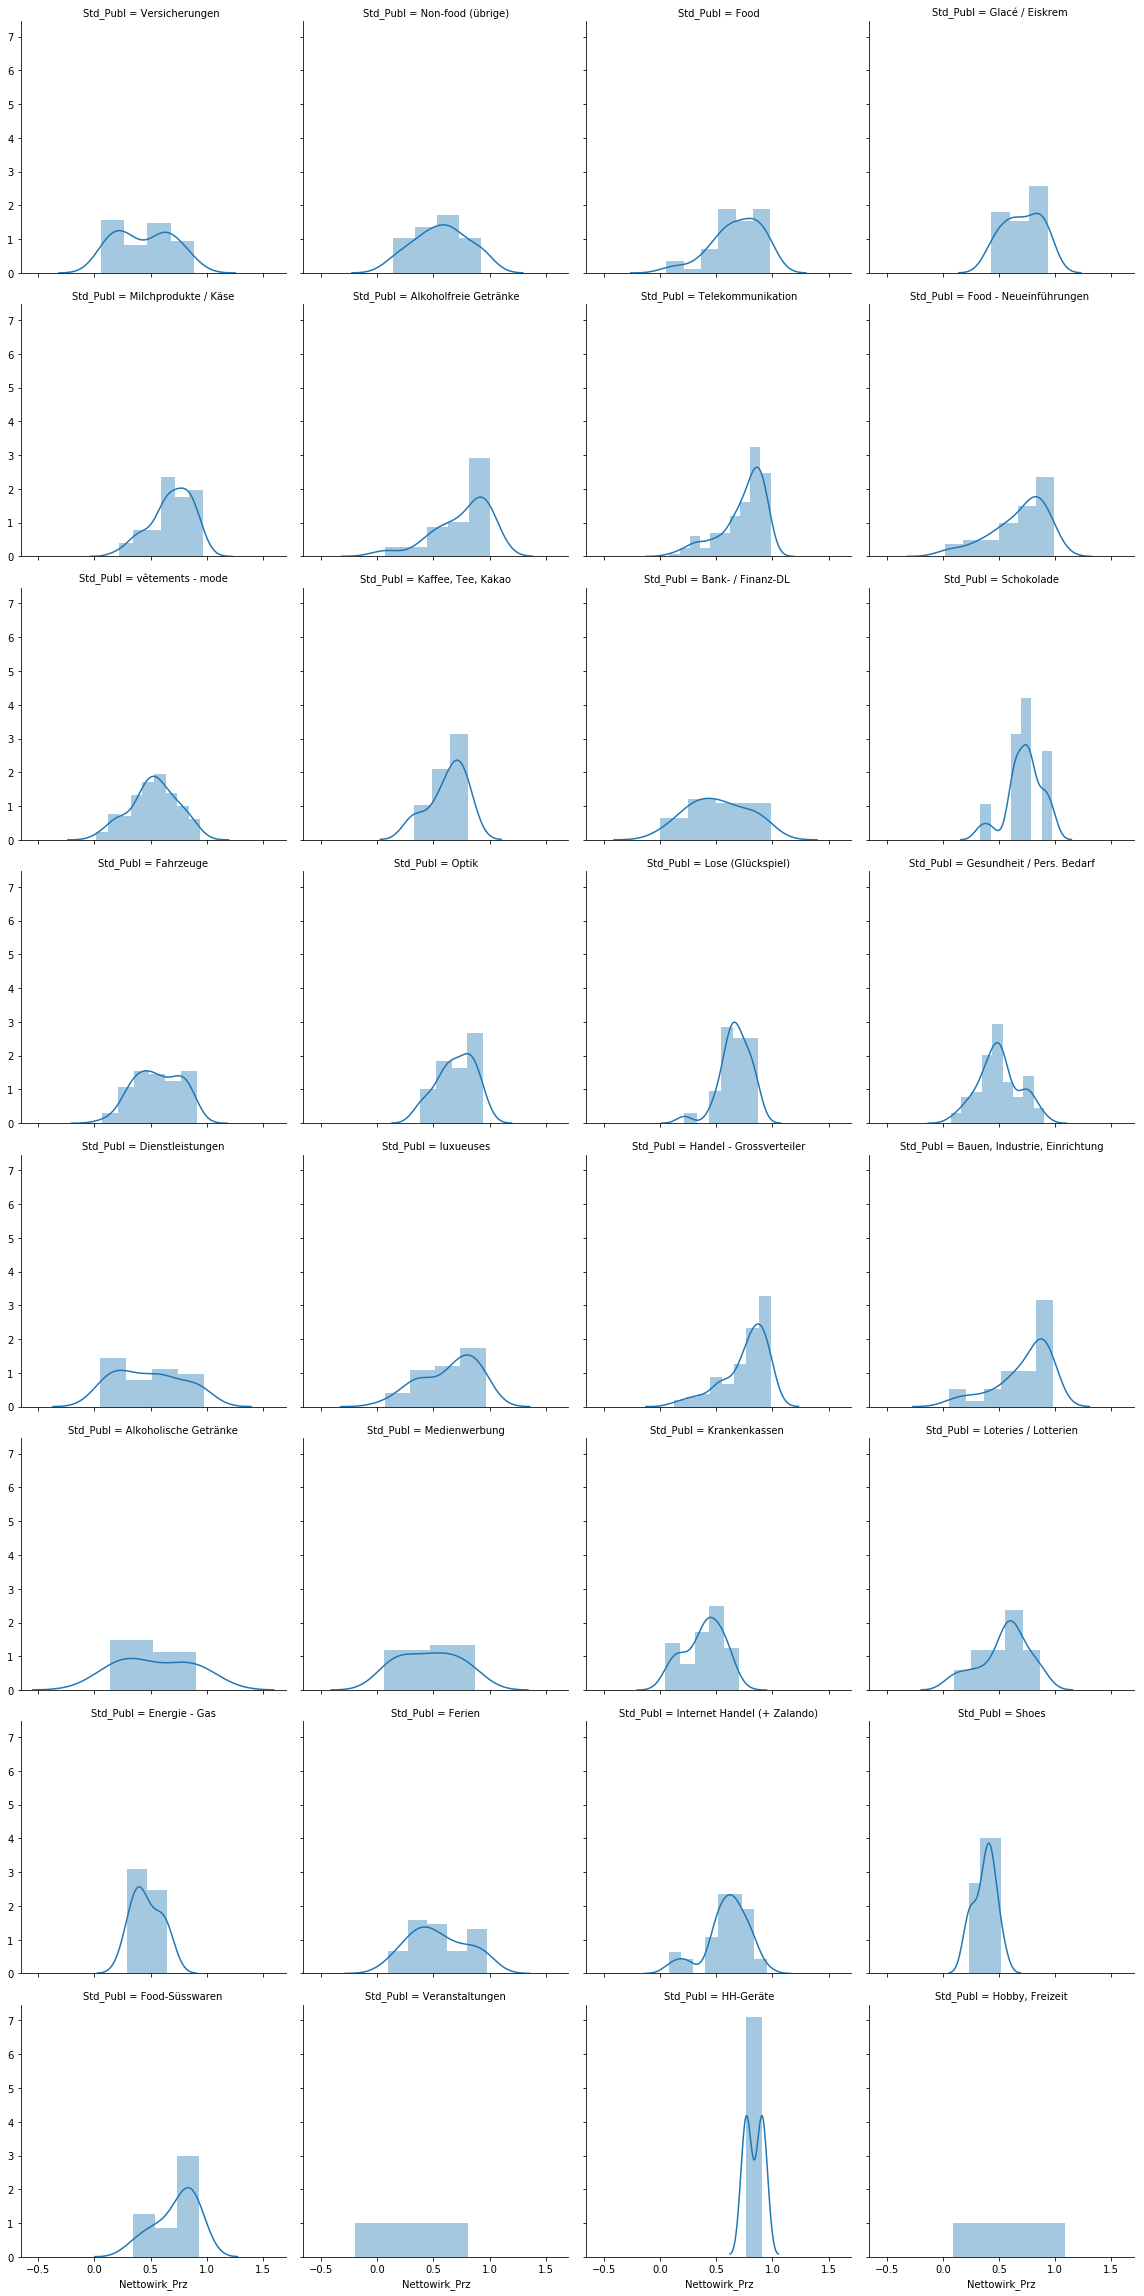

In [22]:
g = sns.FacetGrid(data=ppi_kamp_data, col="Std_Publ", col_wrap=4, height=4)
g.map(sns.distplot, 'Nettowirk_Prz');

#### Check empties on "Marken_Bekanntheit"

In [23]:
def empty(s):
    return all(s.isna())

def full(s):
    return all(s.notna())

def mixed(s):
    return any(s.isna()) and any(s.notna())

display(ppi_data.groupby('Jahr')[['Marke_Bekanntheit']].agg([empty, mixed, full]))
ppi_data.groupby('Jahr')[['Marke_Bekanntheit']].agg([empty, mixed, full]).sum(axis=0)

Marke_Bekanntheit              
                 empty  mixed   full
Jahr                                
2003              True  False  False
2004              True  False  False
2005              True  False  False
2006              True  False  False
2007              True  False  False
2008              True  False  False
2009              True  False  False
2010              True  False  False
2011              True  False  False
2012              True  False  False
2013              True  False  False
2014              True  False  False
2015              True  False  False
2016              True  False  False
2017             False   True  False
2018             False   True  False
2019             False  False   True

Marke_Bekanntheit  empty    14
                   mixed     2
                   full      1
dtype: int64

## Aggregate on campaign / high-low Marken-Bekanntheit

In [24]:
ppi_kamp_hilo_data = (ppi_data.groupby(['Ppi_NR', 'Marke_Bekannt'], observed=True)
                      .agg({'Kunde': 'last', 'Kpg_Name': 'last', 'Branche': 'last', 'Gruppe': 'last', 'Kategorie': 'last', 'Std_Publ': 'last', 
                            'Befr_Erinn_Prz': 'sum', 'Befr_Zuord_Prz': 'sum'})
                      .eval('Nettowirk_Prz = Befr_Zuord_Prz / Befr_Erinn_Prz')
                      .join(ppi_data.groupby(['Ppi_NR', 'Marke_Bekannt'], observed=True).size().rename('Befr_N')))

write_xlsx(ppi_kamp_hilo_data, 'ppi_kamp_hilo.xlsx', 'data')

2019-07-29 14:48:56 [INFO] Writing to file /home/pa/data/ppi_kamp_hilo.xlsx
2019-07-29 14:48:57 [INFO] Written 150.3 KB
2019-07-29 14:48:57 [INFO] Finished writing xlsx file in 0.5s (1.61s CPU)


In [25]:
qshow(ppi_kamp_hilo_data)

QgridWidget(grid_options={'fullWidthRows': False, 'syncColumnCellResize': True, 'forceFitColumns': False, 'def…

In [26]:
_ = aggregate_ppi(ppi_kamp_hilo_data.reset_index(), by_col=['Std_Publ', 'Marke_Bekannt'], ci_method='t')
write_xlsx(_, 'ppi_kamp_hilo_by_std_publ.xlsx', 'data')
_

2019-07-29 14:49:49 [INFO] Writing to file /home/pa/data/ppi_kamp_hilo_by_std_publ.xlsx
2019-07-29 14:49:49 [INFO] Written 18.7 KB
2019-07-29 14:49:49 [INFO] Finished writing xlsx file in 0.04s (0.04s CPU)


Umfragen  Erinn_mean  Erinn_low  \
Std_Publ                      Marke_Bekannt                                    
Alkoholfreie Getränke         high                  3    0.317725   0.198634   
                              low                   3    0.084027   0.000000   
                              not                   3    0.005534   0.000000   
                              unknown              34    0.493135   0.441863   
Alkoholische Getränke         unknown               7    0.328154   0.229719   
Bank- / Finanz-DL             high                  5    0.152062   0.060372   
                              low                   5    0.200673   0.131129   
                              not                   5    0.069111   0.000000   
                              unknown              32    0.434667   0.375823   
Bauen, Industrie, Einrichtung high                  7    0.297793   0.227985   
                              low                   7    0.083442   0.029171   
                              not                   7    0.007111   0.000000   
                              unknown              30    0.430946   0.379385   
Dienstleistungen              high                  6    0.251058   0.023258   
                              low                   6    0.087768   0.038302   
                              not                   6    0.024320   0.000000   
                              unknown              48    0.372623   0.323137   
Energie - Gas                 unknown               9    0.326289   0.184181   
Fahrzeuge                     high                 18    0.176545   0.145661   
                              low                  18    0.143951   0.121717   
                              not                  18    0.021889   0.015942   
                              unknown              56    0.302260   0.279078   
Ferien                        high                  8    0.281348   0.141424   
                              low                   8    0.105969   0.065548   
                              not                   7    0.024784   0.004375   
                              unknown              35    0.386469   0.330448   
Food                          high                  8    0.403921   0.202659   
                              low                   8    0.099969   0.046215   
                              not                   8    0.009062   0.000000   
                              unknown              47    0.417625   0.369427   
Food - Neueinführungen        high                  6    0.274287   0.062267   
                              low                   6    0.062762   0.034751   
                              not                   6    0.014453   0.000000   
                              unknown              44    0.415655   0.369387   
Food-Süsswaren                high                  2    0.231586   0.199884   
                              low                   2    0.114890   0.000000   
                              not                   2    0.016447   0.000000   
                              unknown              10    0.358448   0.273388   
Gesundheit / Pers. Bedarf     high                 15    0.223808   0.183320   
                              low                  15    0.165536   0.130633   
                              not                  15    0.062715   0.028459   
                              unknown              55    0.470498   0.420875   
Glacé / Eiskrem               high                  1    0.124113        NaN   
                              low                   1    0.237098        NaN   
                              not                   1    0.165496        NaN   
                              unknown              22    0.538436   0.467423   
HH-Geräte                     high                  1    0.155095        NaN   
                              low                   1    0.143594        NaN   
                              not            

#### Plot answer distributions

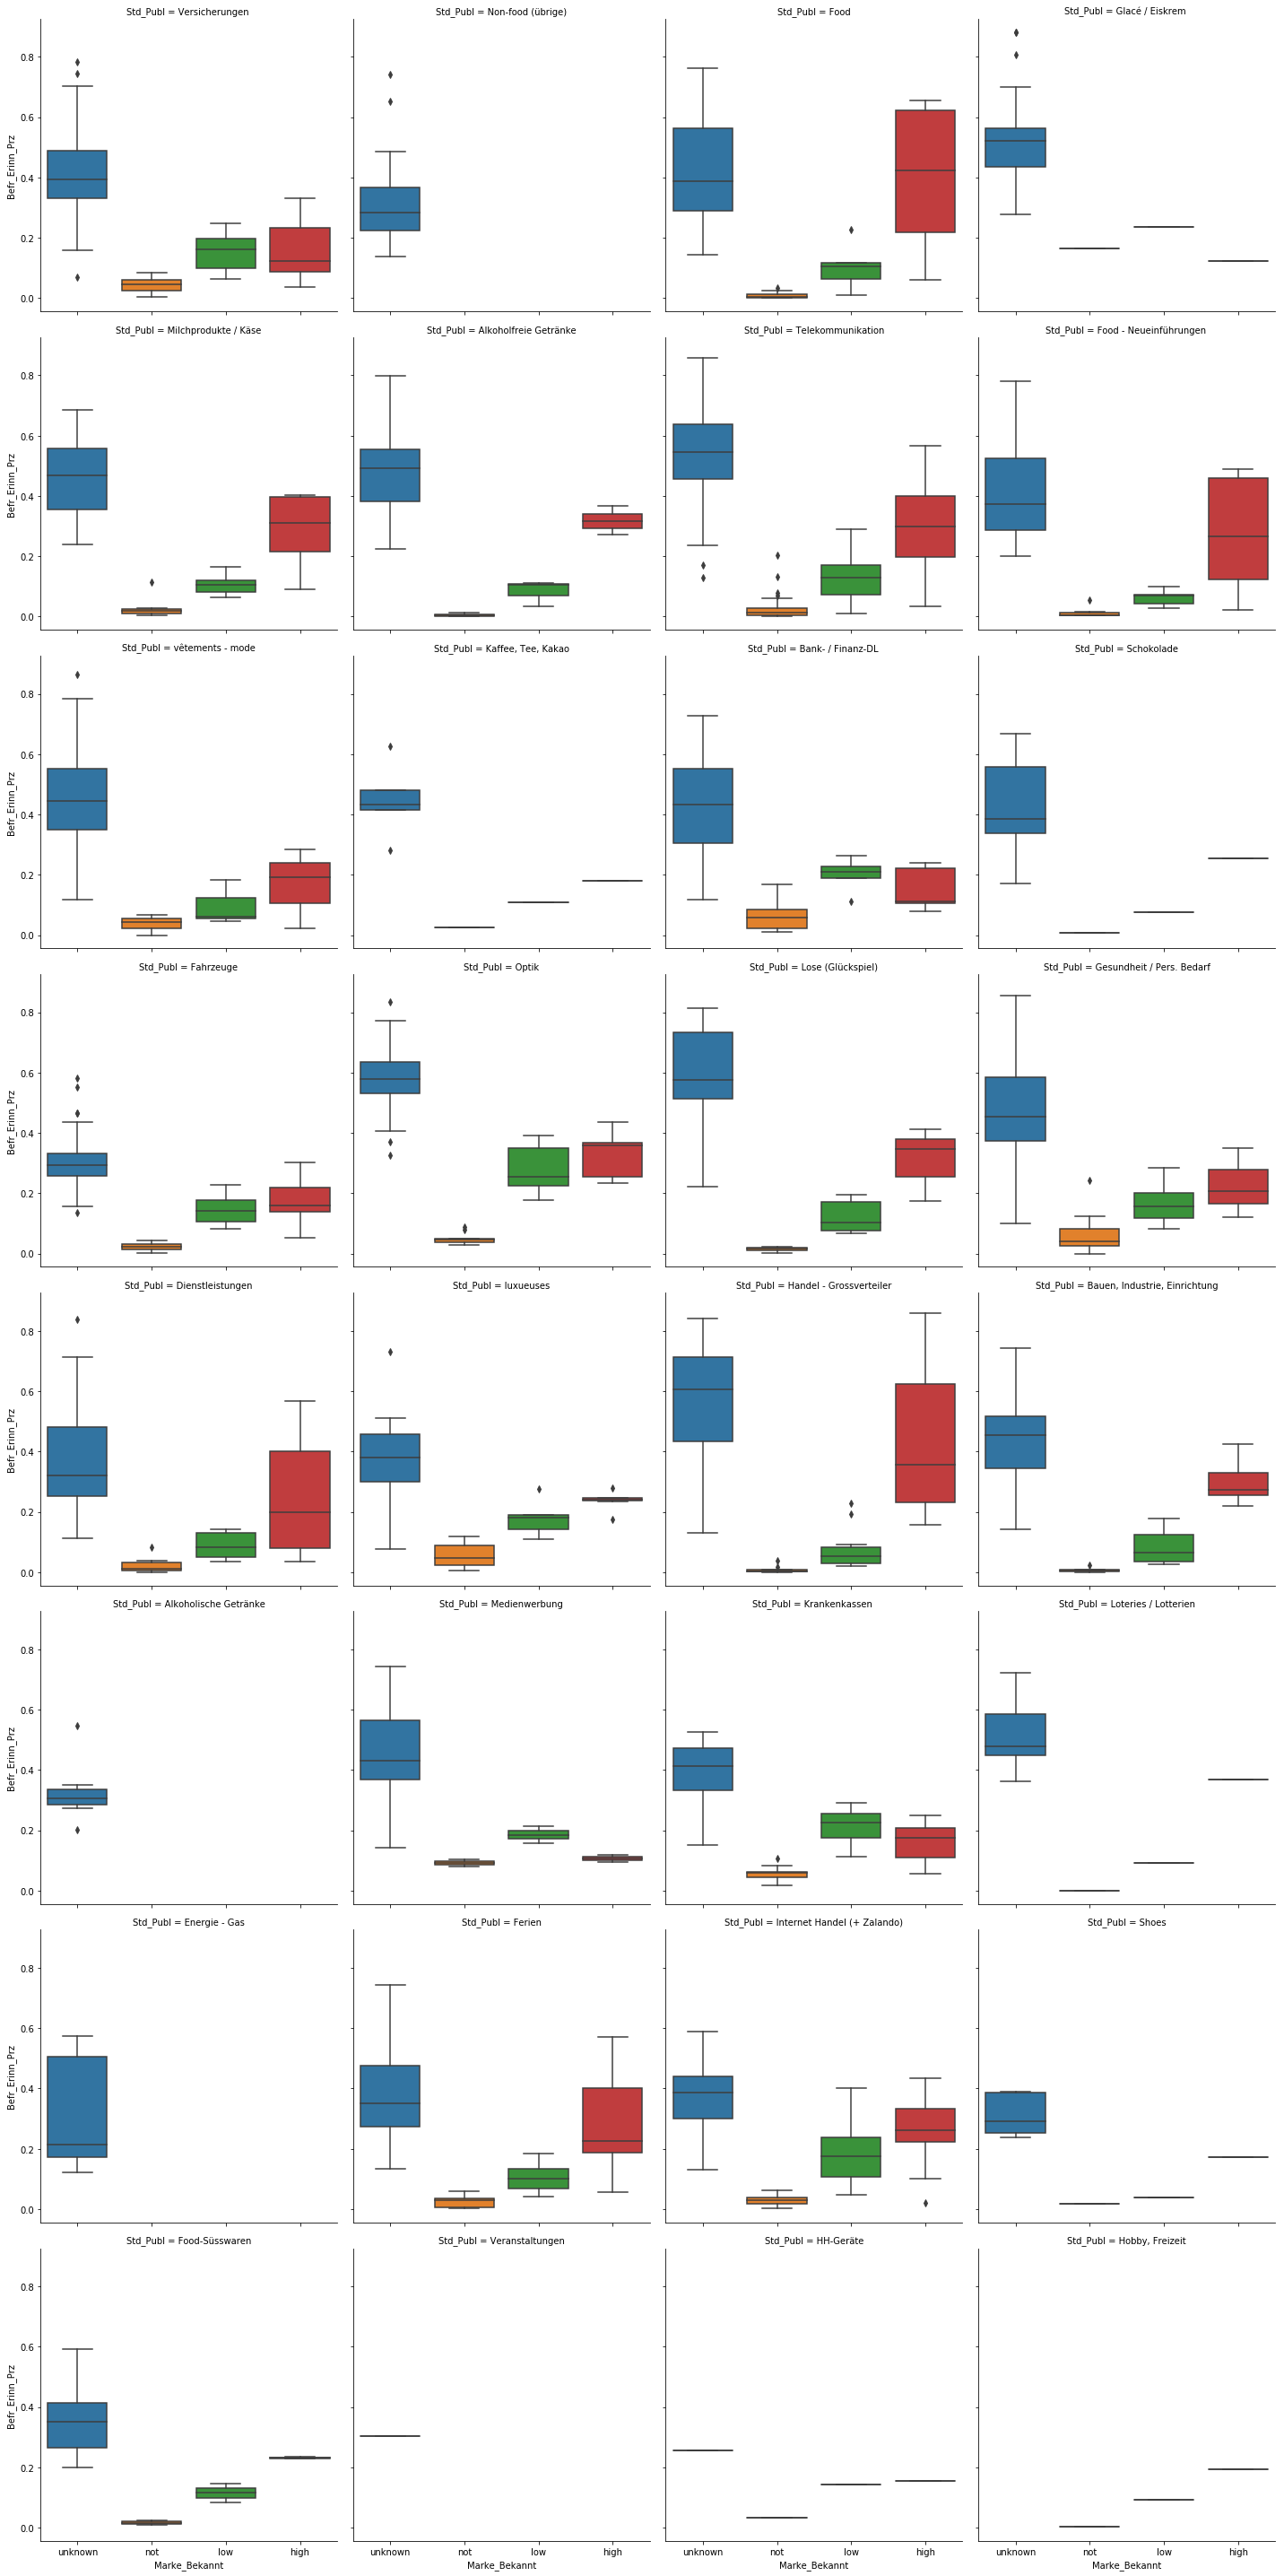

In [27]:
g = sns.catplot(data=ppi_kamp_hilo_data.reset_index(), x='Marke_Bekannt', order=['unknown', 'not', 'low', 'high'], 
                y='Befr_Erinn_Prz', col='Std_Publ', col_wrap=4, height=5, kind='box')

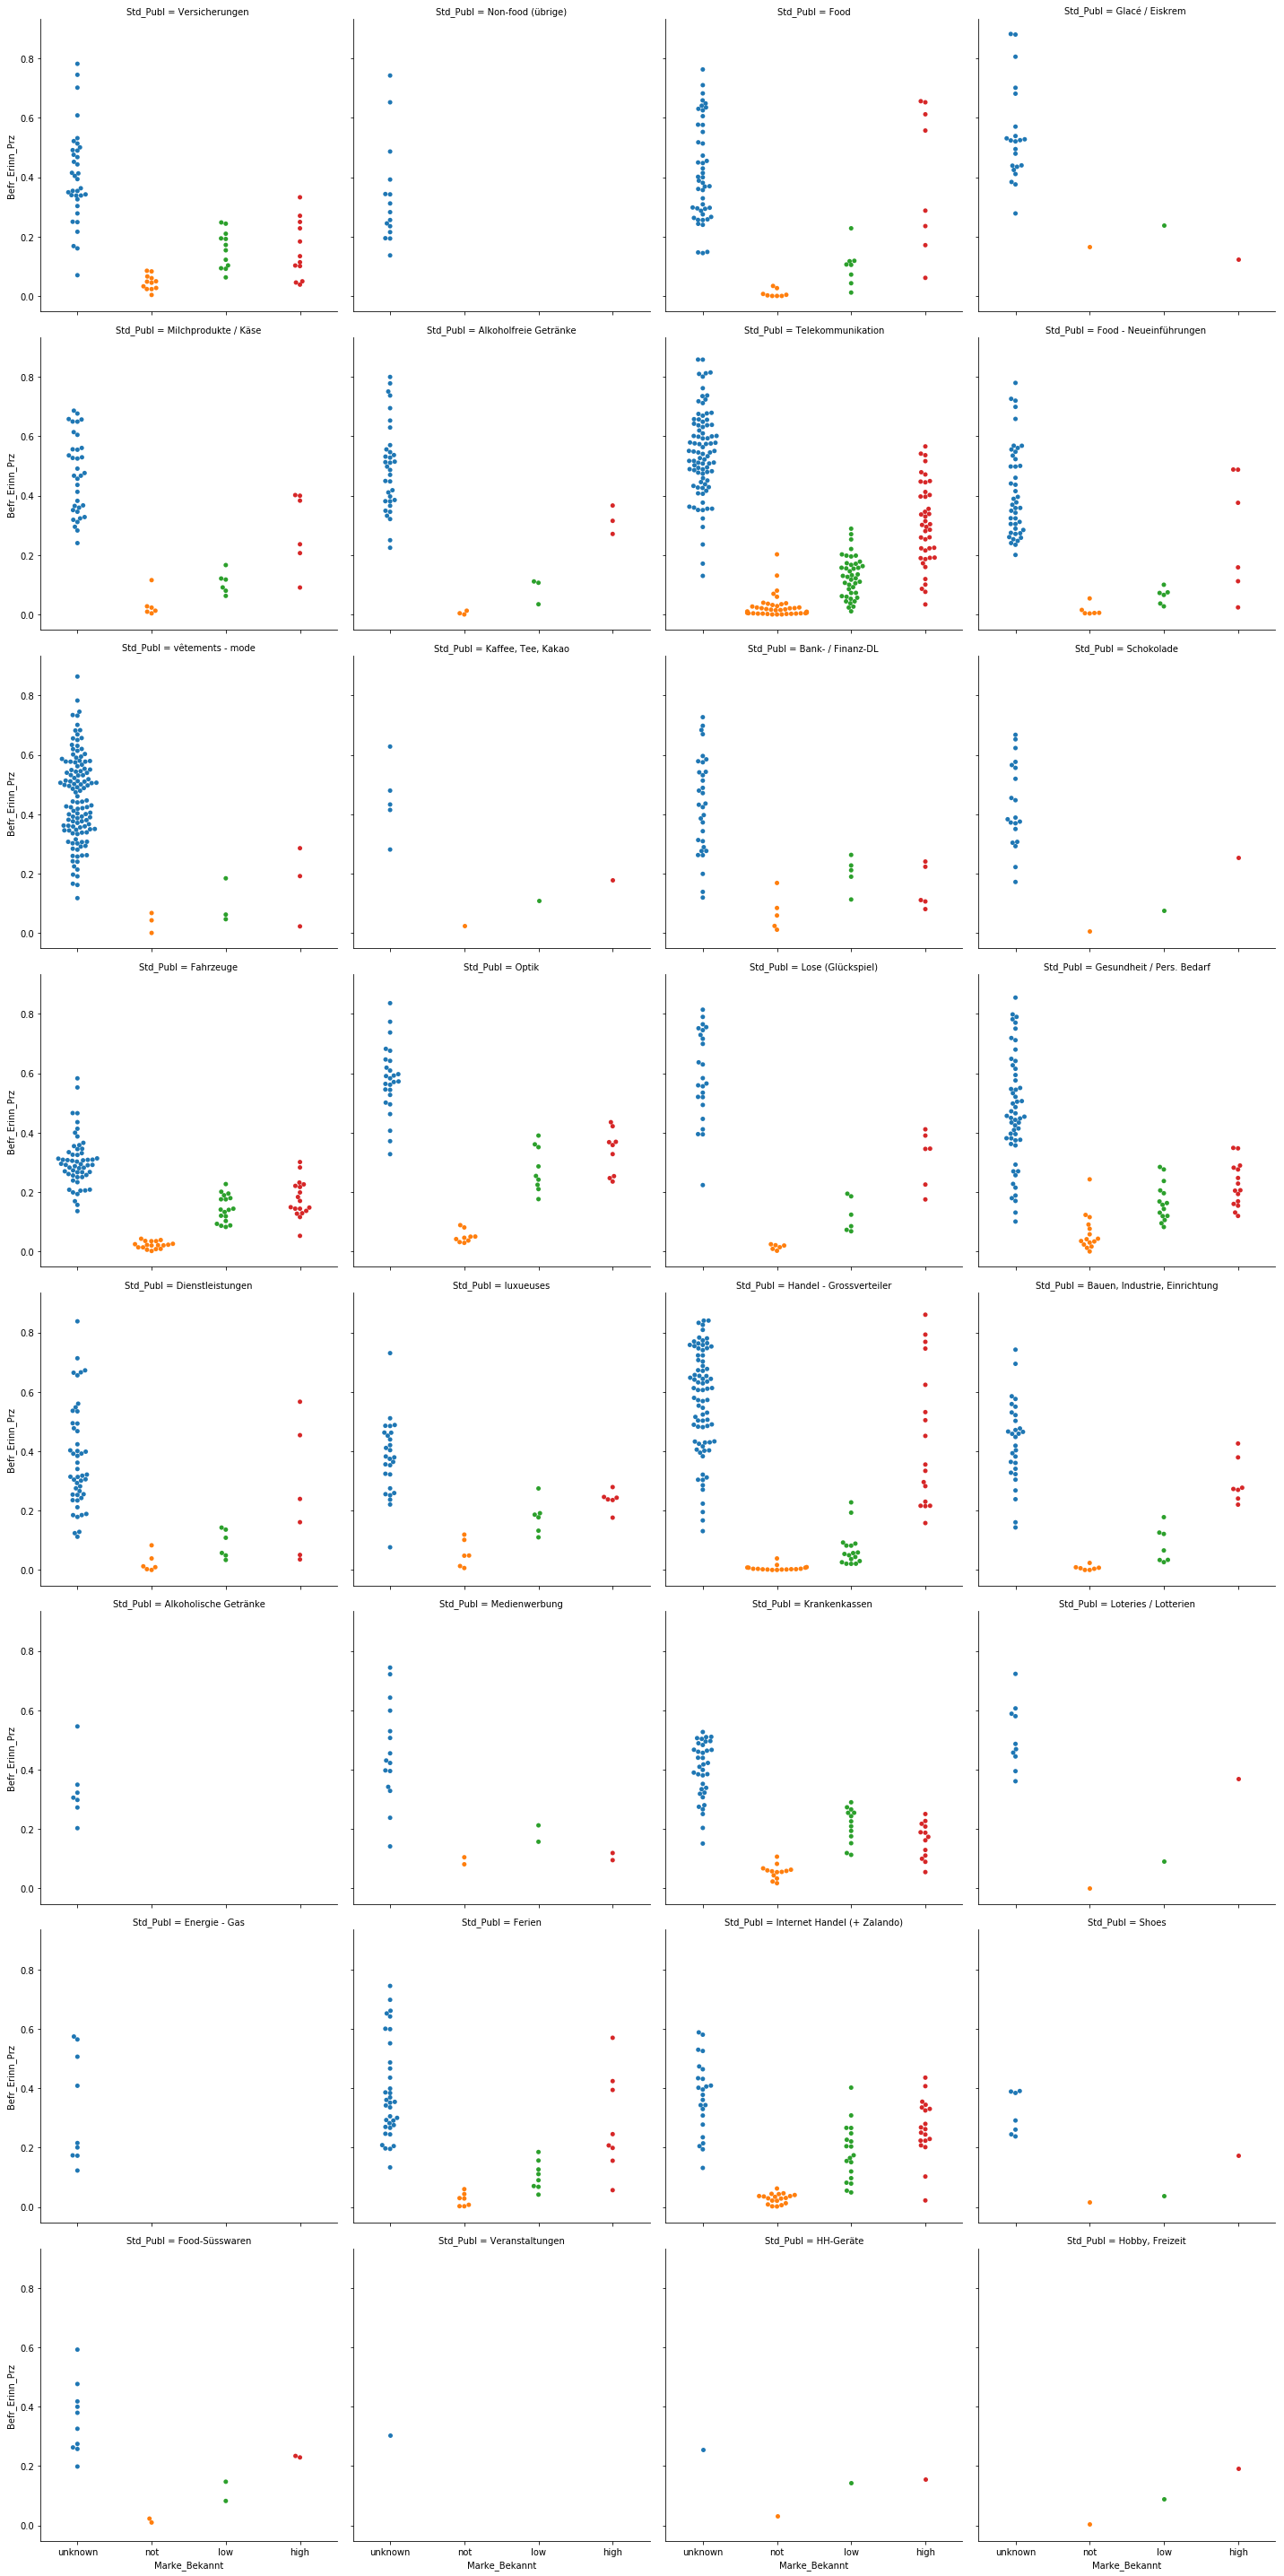

In [28]:
g = sns.catplot(data=ppi_kamp_hilo_data.reset_index(), x='Marke_Bekannt', order=['unknown', 'not', 'low', 'high'], 
                y='Befr_Erinn_Prz', col='Std_Publ', col_wrap=4, height=5, kind='swarm')

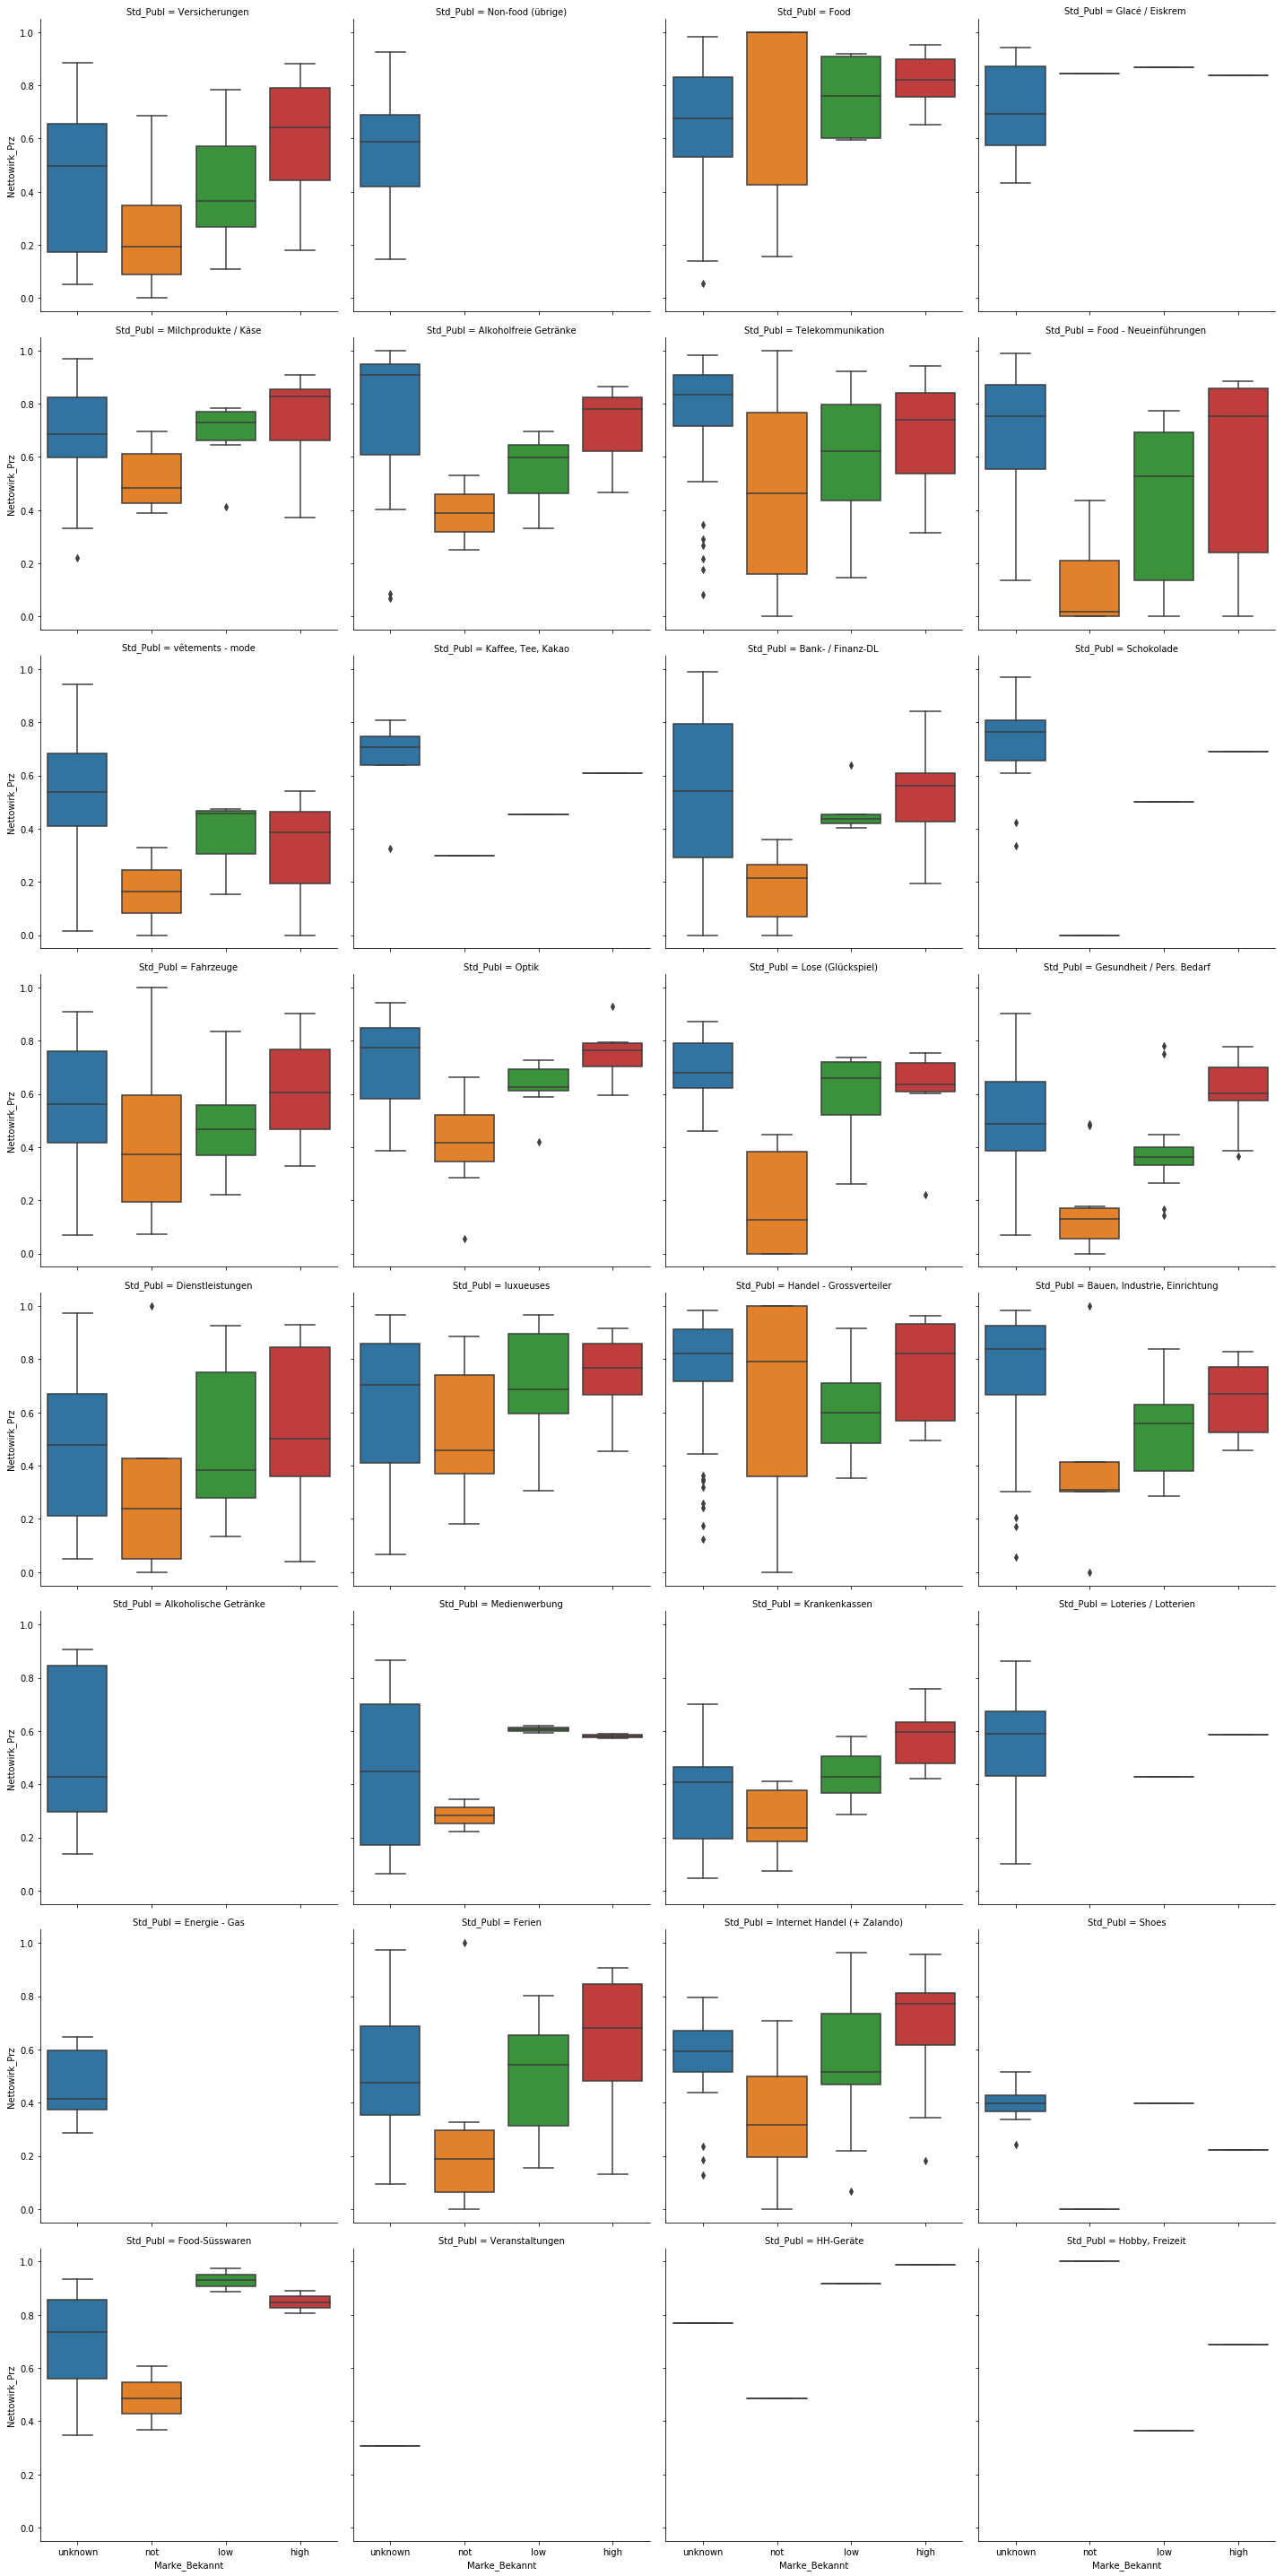

In [29]:
g = sns.catplot(data=ppi_kamp_hilo_data.reset_index(), x='Marke_Bekannt', order=['unknown', 'not', 'low', 'high'], 
                y='Nettowirk_Prz', col='Std_Publ', col_wrap=4, height=5, kind='box')

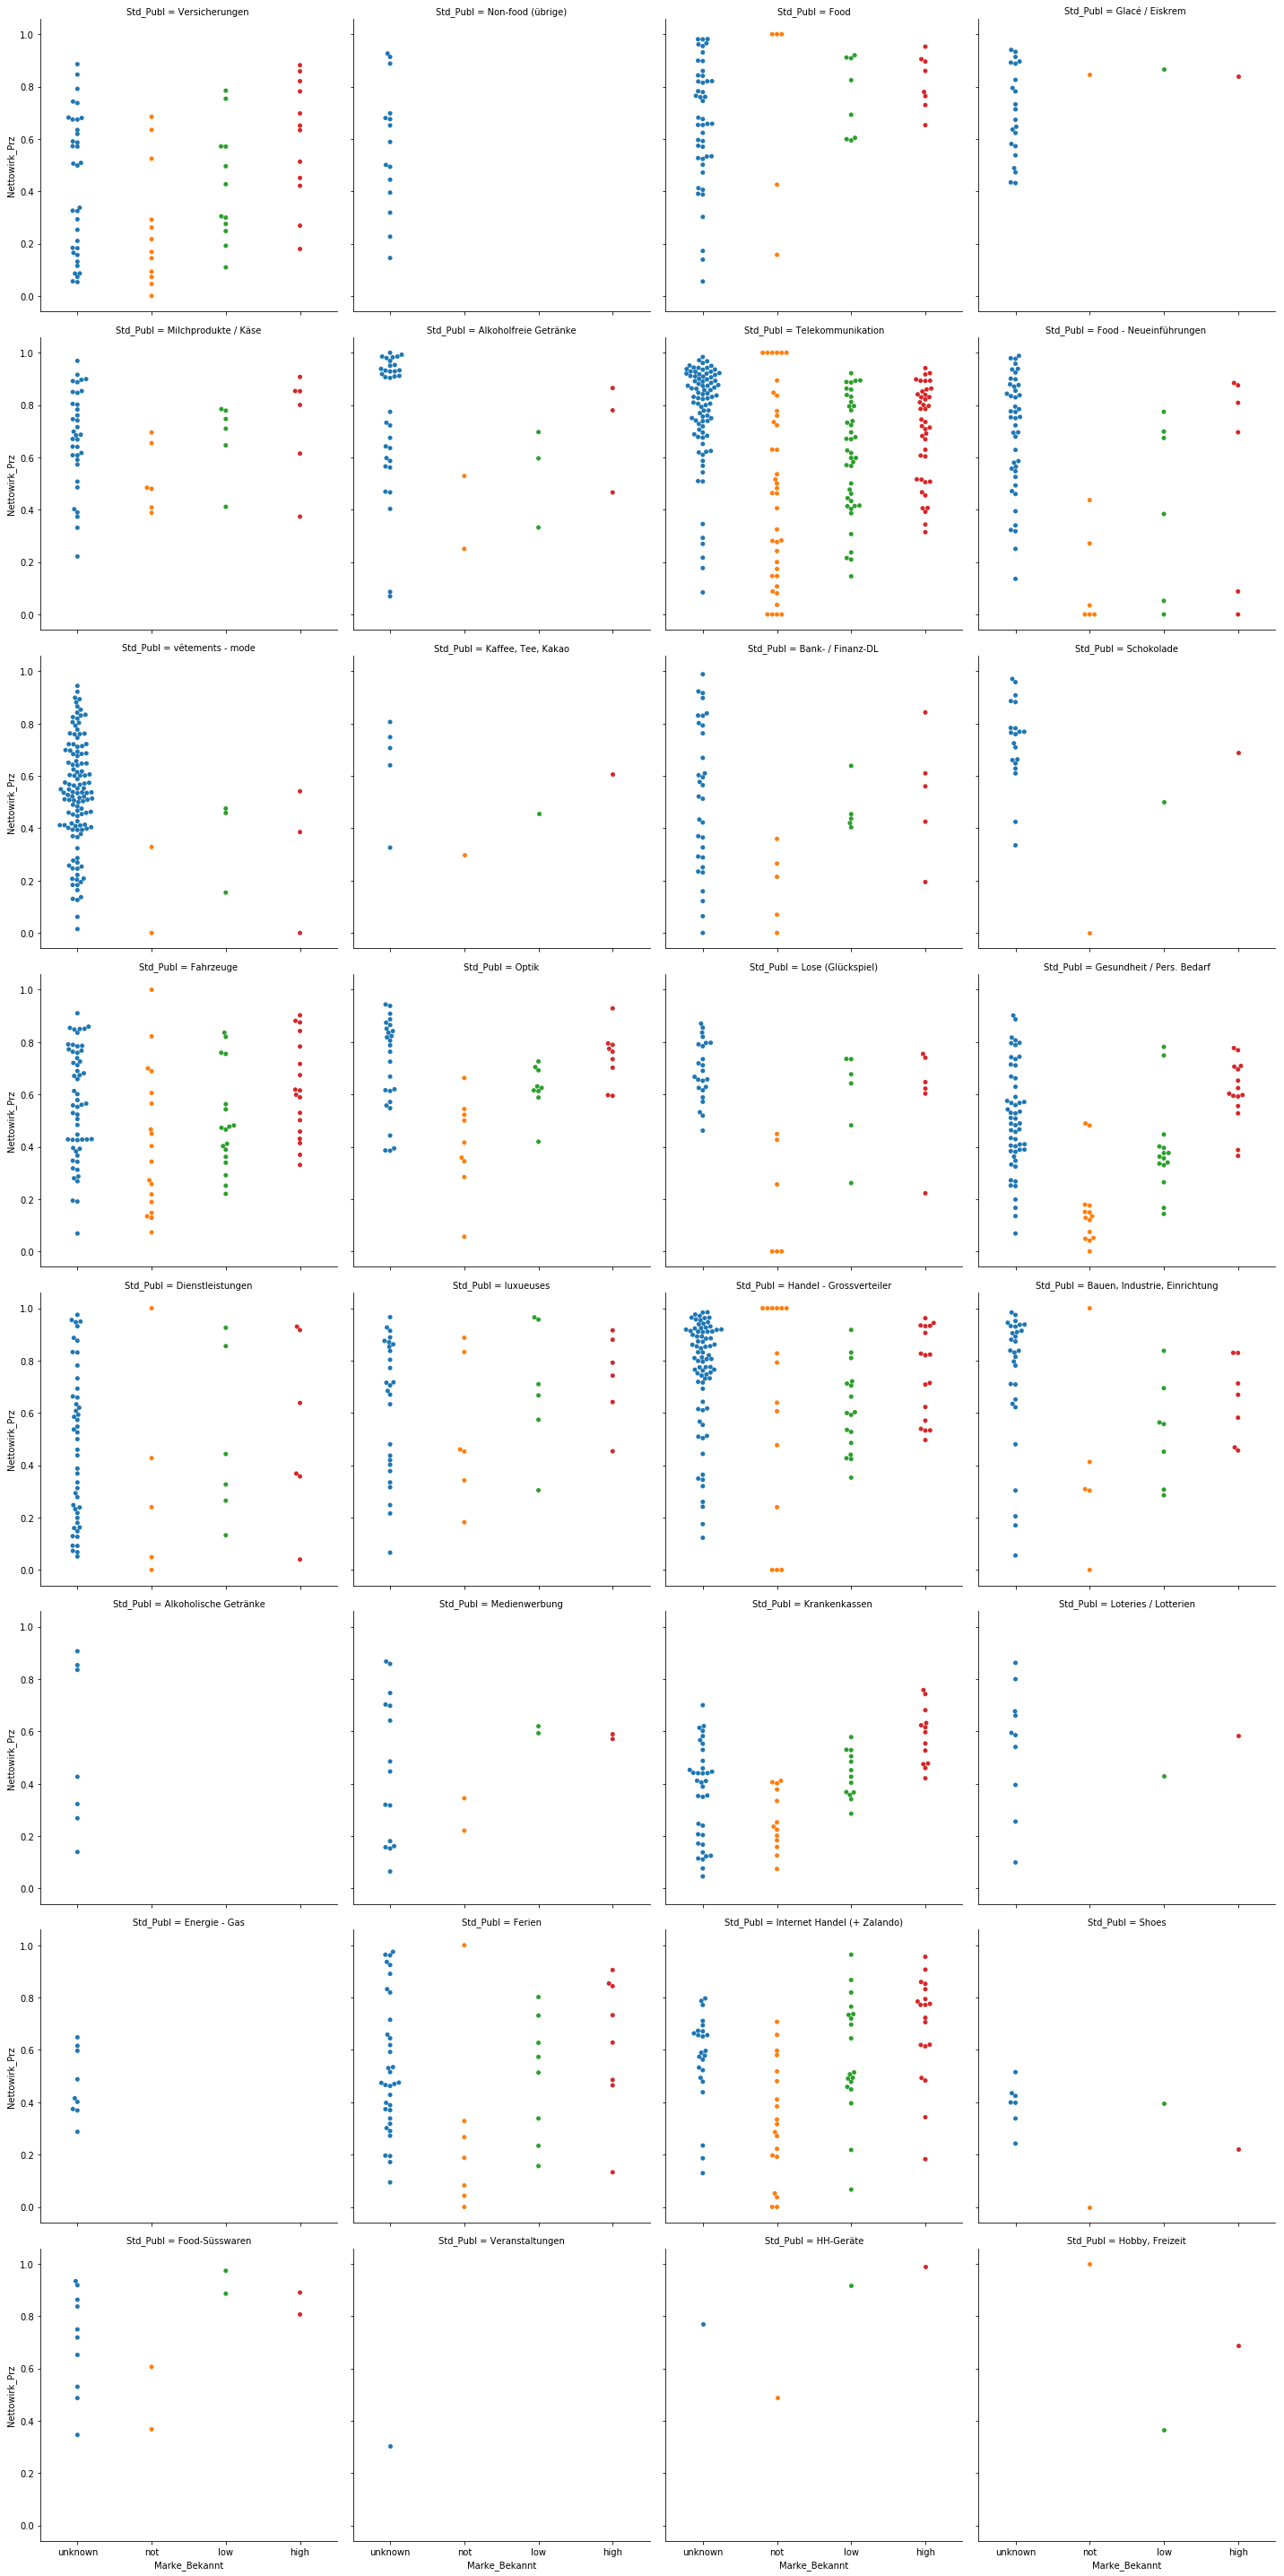

In [30]:
g = sns.catplot(data=ppi_kamp_hilo_data.reset_index(), x='Marke_Bekannt', order=['unknown', 'not', 'low', 'high'], 
                y='Nettowirk_Prz', col='Std_Publ', col_wrap=4, height=5, kind='swarm');